## Lab # 1
_Team i_ <br>
Kozlyak Ruslan, Roman Visotskiy, Egor Shmelev

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import stats
from tqdm import tqdm
import math
from scipy.optimize import least_squares, minimize
import scipy.stats as st
from scipy.stats import betabinom
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Dataset representation

## We use the following dataset

This document explores a dataset containing prices and attributes for approximately 54,000 round-cut diamonds.
There are 53,940 diamonds in the dataset with 10 features (carat, cut, color, clarity, depth, table, price, x, y, and z). Most variables are numeric in nature, but the variables cut, color, and clarity are ordered factor variables with the following levels.


https://www.kaggle.com/datasets/nancyalaswad90/diamonds-prices

In [ ]:
data = pd.read_csv('Diamonds Prices2022.csv', index_col=0)

cut_factor = pd.factorize(data['cut'])
data['cut'] = cut_factor[0]

color_factor = pd.factorize(data['color'])
data['color'] = color_factor[0]

color_factor = pd.factorize(data['clarity'])
data['clarity'] = color_factor[0]

In [ ]:
data

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,0,0,0,61.5,55.0,326,3.95,3.98,2.43
2,0.21,1,0,1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,2,0,2,56.9,65.0,327,4.05,4.07,2.31
4,0.29,1,1,3,62.4,58.0,334,4.20,4.23,2.63
5,0.31,2,2,0,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53939,0.86,1,3,0,61.0,58.0,2757,6.15,6.12,3.74
53940,0.75,0,6,0,62.2,55.0,2757,5.83,5.87,3.64
53941,0.71,1,0,1,60.5,55.0,2756,5.79,5.74,3.49
53942,0.71,1,4,1,59.8,62.0,2756,5.74,5.73,3.43


In [ ]:
y = data.price
x = data.drop(['price'], axis='columns')

# Non-parametric estimation of PDF in form of histogram and using kernel density function / probability law

In [ ]:
continious_cols = ["carat", "depth", "table", "x", "y", "z"]
discrite_cols = ["cut","color", "clarity"]

rows_count, columns_count = x.shape

3it [00:00,  5.55it/s]


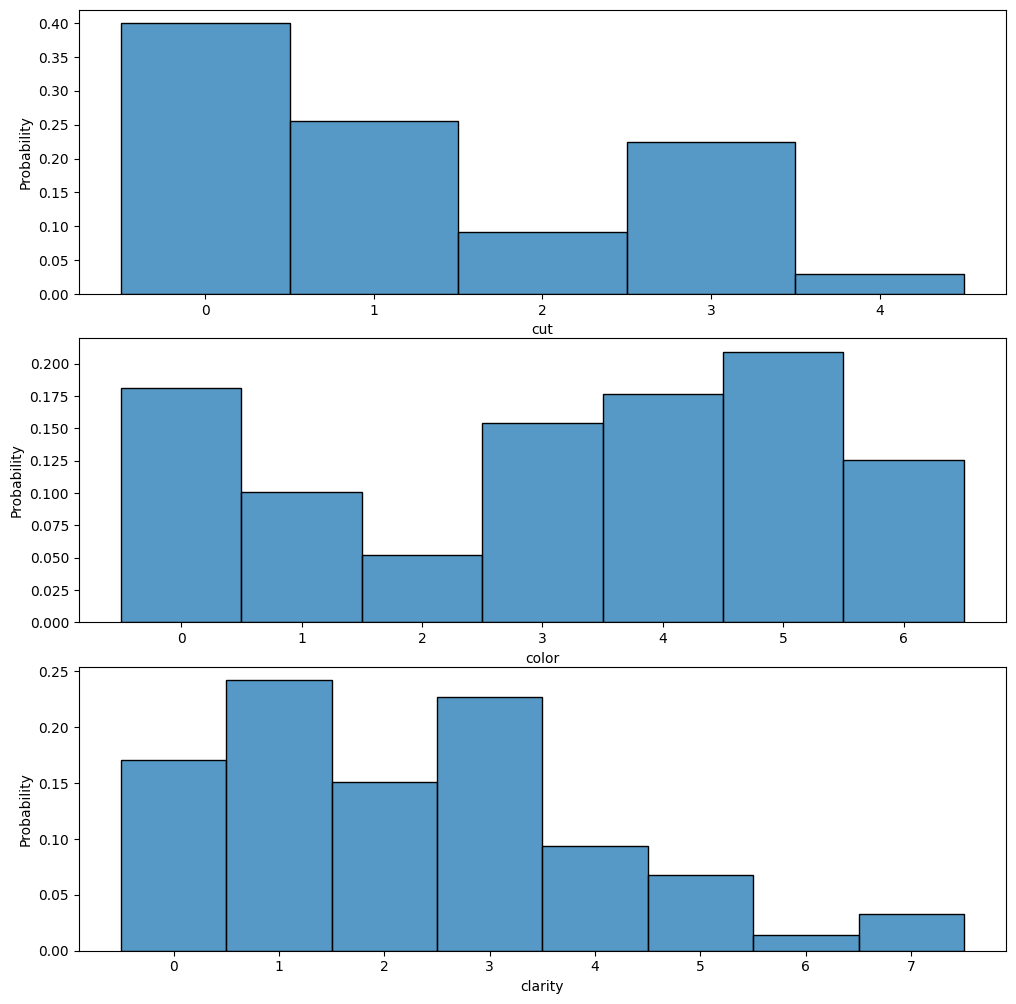

In [ ]:
nrows=len(discrite_cols)

fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(10,  nrows*3+1))
fig.tight_layout()

for i, column in tqdm(enumerate(discrite_cols)):
    sns.histplot(x[column], ax=axes[i], stat="probability", discrete=True)

6it [00:04,  1.27it/s]


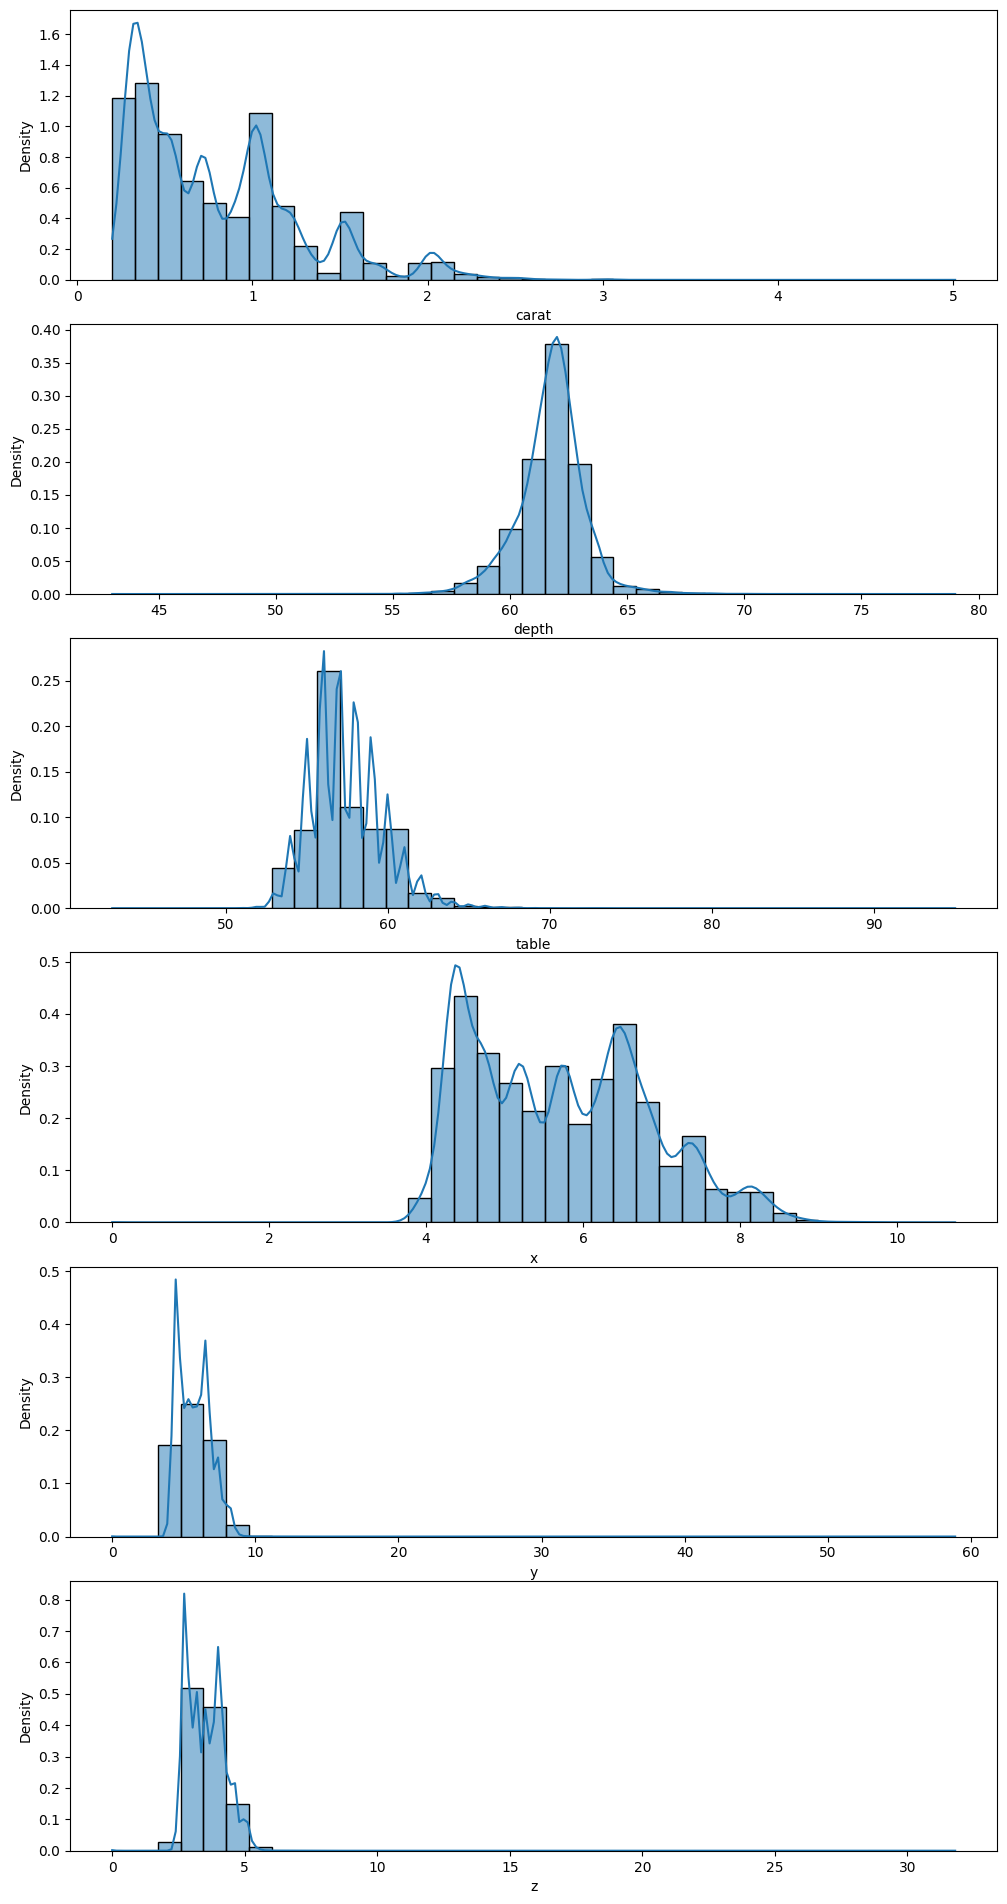

In [ ]:
nrows=len(continious_cols)

fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(10,  nrows*3+1))
fig.tight_layout()

for i, column in tqdm(enumerate(continious_cols)):
    sns.histplot(x[column], ax=axes[i], kde=True, stat="density", bins=int(1 + 3.32 * math.log(rows_count)))

# Estimation of order statistics and represent them as “box with whiskers” plot

9


9it [00:00, 50.28it/s]


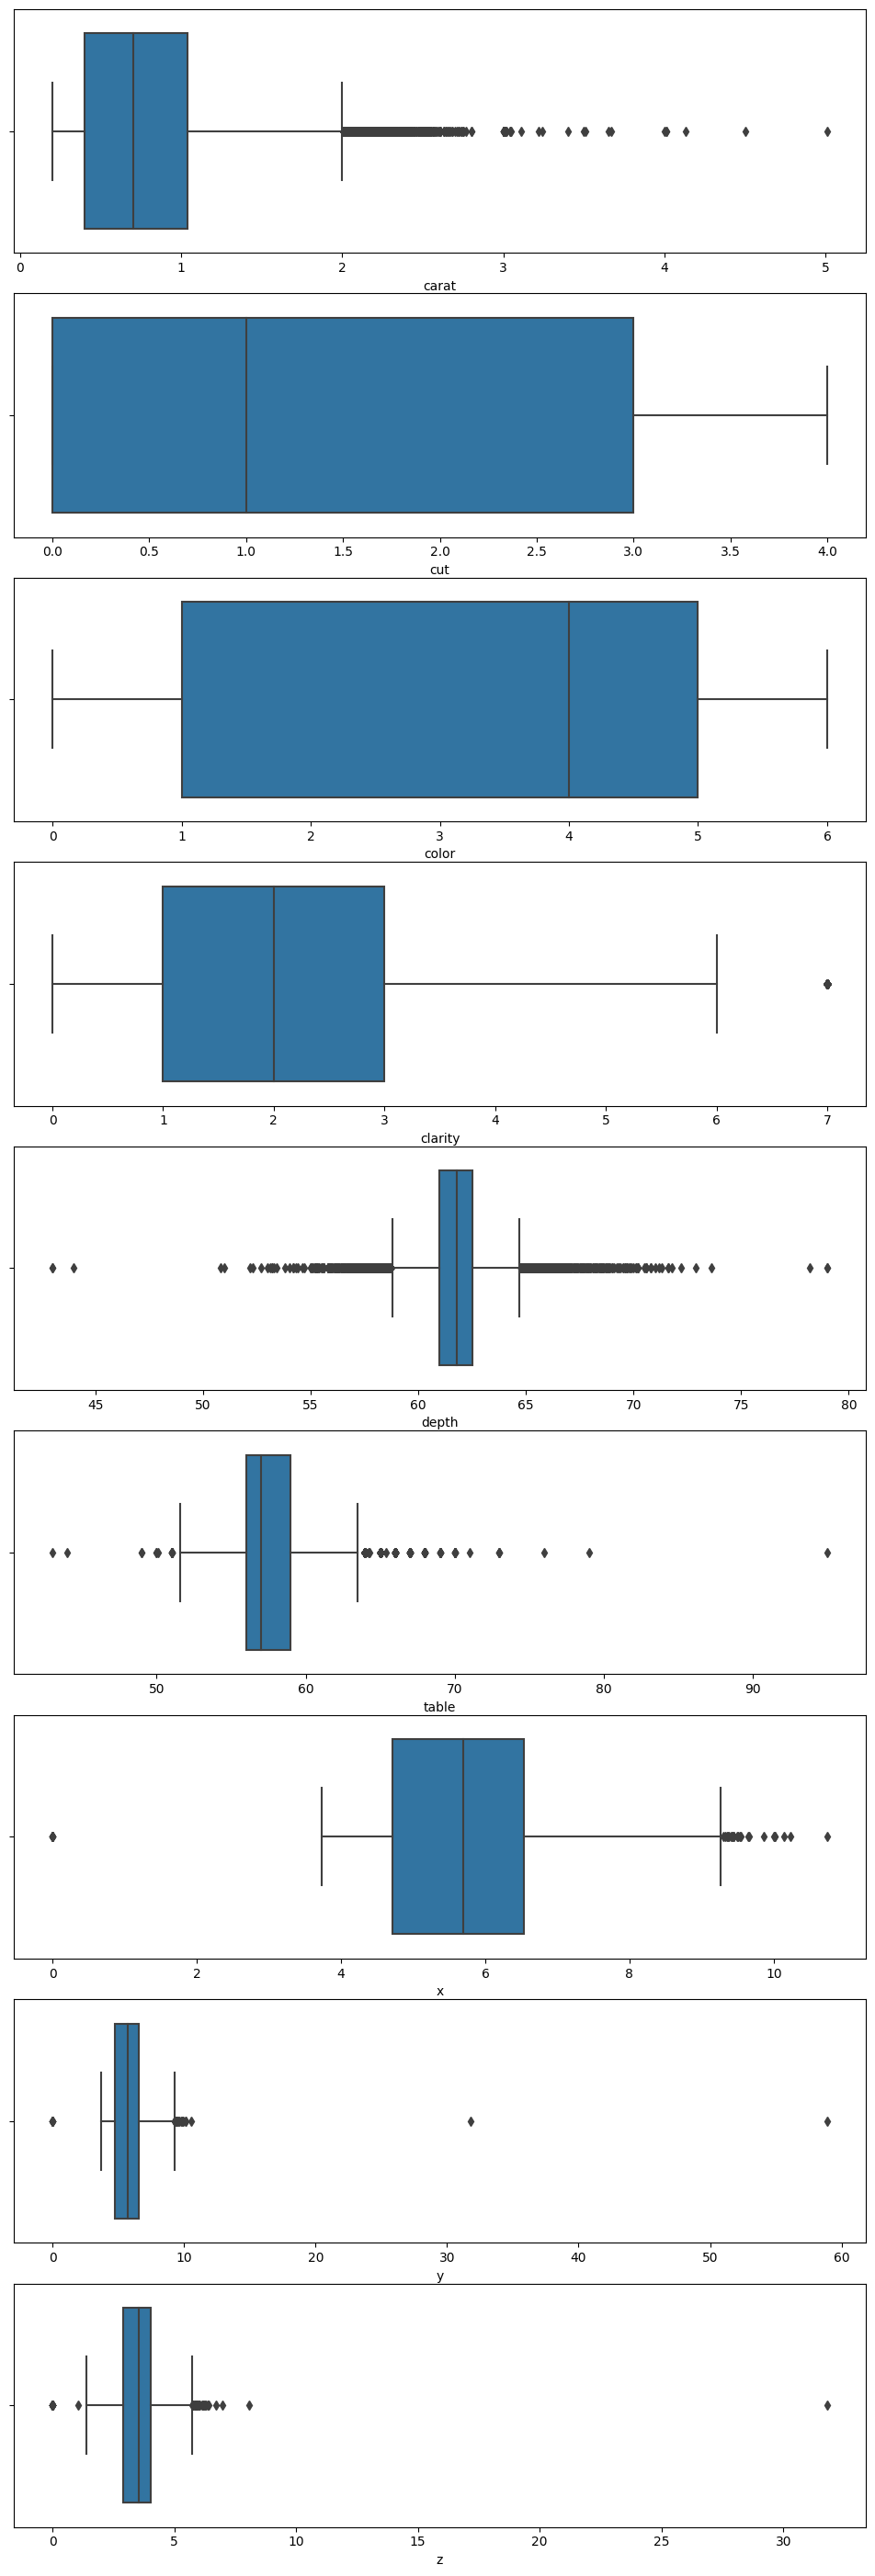

In [ ]:
n_rows = len(x.columns)
print(n_rows)
fig, axes = plt.subplots(nrows=n_rows, ncols=1, figsize=(10, n_rows*3+1))
fig.tight_layout()

for i, column in tqdm(enumerate(x)):
    sns.boxplot(data=x, x=column, ax=axes[i])

# Theoretical distributions that could describe the sample +
# Parameters estimation of chosen distributions using methods of maximum likelihood and least squares method

In [ ]:
# leave 4 continuous features and 1 categorical feature
data_main = data.copy()
data_main.drop(columns=['y','z','price'], inplace=True)
data_cl = data['clarity']

In [ ]:
# continious features
# 1. detection of best distribution:
DISTRIBUTIONS = [
    st.norm, # Normal distribution
    st.expon, # Exponential distribution
    st.gamma, # Gamma distribution
    st.beta, # Beta distribution
    st.lognorm, # Lognormal distribution
    st.uniform, # Uniform distribution
    st.t, # Student's t-distribution
    st.chi2, # Chi-squared distribution
    st.weibull_min, # Weibull distribution (minimum)
    st.pareto # Pareto distribution
]

def best_fit_distribution(data, bins=200):
    """Model data by finding best fit distribution to data"""
    distributions = DISTRIBUTIONS
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    best_distribution = None
    best_params = None
    best_sse = np.inf

    for distribution in distributions:
        try:
            params = distribution.fit(data)
            pdf = distribution.pdf(bin_centers, *params)
            sse = np.sum(np.power(hist - pdf, 2.0))

            if sse < best_sse:
                best_distribution = distribution
                best_params = params
                best_sse = sse
        except:
            continue

    return (best_distribution, best_params)

# 2. Parameters estimation:

def mle_params(distribution, data):
    return distribution.fit(data)

def residuals(params, data, distribution):
    hist, bin_edges = np.histogram(data, bins=len(data), density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    expected = distribution.pdf(bin_centers, *params)
    return hist - expected

def ls_params(distribution, data):
    initial_guess = mle_params(distribution, data)
    result = least_squares(residuals, initial_guess, args=(data, distribution))
    return result.x

def plot_best_fit(data, distribution, params, col):
    """Plot original data with best fit distribution."""
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Plot original data in histogram
    ax.hist(data, bins=50, density=True, alpha=0.6, color='b')

    # Plot the best fit distribution
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    pdf = distribution.pdf(x, *params)
    ax.plot(x, pdf, 'k', linewidth=2, label=distribution.name)

    title = f"Fit results ({col}): {distribution.name}"
    ax.set_title(title)
    plt.legend()
    plt.show()

data_samples = {"carat": data_main['carat'] ,"depth": data_main['depth'] ,
                "table": data_main['table'] , "x": data_main['x']}

for key, data in data_samples.items():
    best_distribution, best_params = best_fit_distribution(data)
    print(f"For {key}: Best fit distribution: {best_distribution.name}")

    mle_parameters = mle_params(best_distribution, data)
    print(f"MLE parameters: {mle_parameters}")

    ls_parameters = ls_params(best_distribution, data)
    print(f"Least Squares parameters: {ls_parameters}\n")

    plot_best_fit(data, best_distribution, best_params, col=key)

In [ ]:
# defining parameters for the categorical feature "clarity"
def neg_log_likelihood(params, data, n):
    a, b = params
    return -np.sum(betabinom.logpmf(data, n, a, b))

n = 7

# initial values for alpha and beta
initial_params = [1, 1]

result = minimize(neg_log_likelihood, initial_params, args=(data_cl, n), bounds=((0, None), (0, None)))

alpha_mle, beta_mle = result.x
print(f"Alpha (MLE): {alpha_mle}")
print(f"Beta (MLE): {beta_mle}")


In [ ]:
def residuals(params, data, n):
    a, b = params
    observed_freqs = np.bincount(data, minlength=n+1) / len(data)
    expected_probs = betabinom.pmf(np.arange(n+1), n, a, b)
    return np.sum((observed_freqs - expected_probs)**2)

result_ls = minimize(residuals, initial_params, args=(data_cl, n), bounds=((0, None), (0, None)))

alpha_ls, beta_ls = result_ls.x
print(f"Alpha (LS): {alpha_ls}")
print(f"Beta (LS): {beta_ls}")


In [ ]:
values, counts = np.unique(data_cl, return_counts=True)

probs_observed = counts / counts.sum()

probs_expected = betabinom.pmf(values, n, alpha_mle, beta_mle)

plt.figure(figsize=(10,6))
plt.bar(values, probs_observed, width=0.4, align='center', label='Observed', alpha=0.7)
plt.plot(values, probs_expected, 'o-', color='red', label=f'Beta-binomial (alpha={alpha_mle:.2f}, beta={beta_mle:.2f})')
plt.xlabel('Clarity Value')
plt.ylabel('Probability')
plt.title('Observed vs Expected Probabilities for Clarity')
plt.xticks(values)
plt.legend()
plt.show()

# Validation of estimated parameters using QQ biplots

# Correctness estimation of fitted distributions